<table align="left">
  <td>
    <a href="https://tinyurl.com/2h6nhlv3" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Transfer Learning con TensorFlow

## Parte 3. Scaling up

En la parte 1 y 2, hemos visto la potencia de transfer learning con TensorFlow. En esta parte, vamos a ver cómo escalarlo para trabajar con conjuntos de datos más grandes.

Es una práctica común en machine learning y deep learning, crear un modelo que funcione con un conjunto de datos pequeños antes de escalarlo para trabajar con conjuntos de datos más grandes.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png" alt="scaling-up" border="0" width = "700">

:book: **En este notebook vamos a ver lo siguiente**:

- Descargar y preparar 10% de los datos de Food101 (10% de datos de entrenamiento).
- Entrenar un modelo de extracción de características transfer learning con 10% de los datos de Food101.
- Fine-tuning el modelo de extracción de características.
- Salvar y cargar el modelo entrenado.
- Evaluar el rendimiento del modelo entreado con el 10% de los datos de Food101.
    - Encontrar las peores predicciones del modelo entrenado.
- Realizar predicciones con el modelo entrenado para Food101 con imágenes personalizadas de comida.


## 1. Descargar y preparar 10% de los datos de Food101

Hasta ahora, se han realizado pruebas utilizando solo 10 clases de Food101. Ahora se utilizarán las 101 clases de Food101. En el dataset original [Food101](https://www.kaggle.com/datasets/dansbecker/food-101), hay 1000 imágenes de cada clase (750 de entrenamiento, 250 de prueba) para un total de 101,000 imagenes. 

En este caso, se utilizarán 10% de los datos de Food101 (10% de datos de entrenamiento). Esto significa que se utilizarán 75 imágenes de cada clase para entrenamiento y 250 de prueba.


In [1]:
import tensorflow as tf
import helper_functions as hf
import numpy as np
import os

In [2]:
# Quitar los comentarios si se desea descargar el dataset de la nube
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

#hf.unzip_data("101_food_classes_10_percent.zip")

In [3]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
# Cuantas imagenes/clases hay en la carpeta descargada
hf.walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
# Configurar los datos de entrada
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode ="categorical", 
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis                                                                                

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## 2. Entrenar un modelo de extracción de características transfer learning con 10% de los datos de Food101

Para mantener la secuencia experimental de las partes anteriores, empezaremos entrenando un modelo de extracción de características con un modelo pre-entrenado por pocas epocas y luego lo fine-tuning por un número adicional de epocas.

:eye: De forma mas especifica, queremos ver si podemos vencer el rendimiento base del articulo [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% de accuracy con 101 clases) utilizando 10% de los datos de entrenamiento de Food101. Se seguirán los siguientes pasos: 

1. Implementar una función ModelCheckpoint para salvar el modelo el progreso del entrenamiento.
2. Agregar data augmentation directamente al modelo. 
3. Utilizar el modelo pre-entrenado EfficientNetB0 de `tf.keras.applications` si la capa superior, para extraer características de las imágenes de Food101.
4. Utilizar una capa densa con 101 neuronas y una función de activación softmax para predecir las clases de las imágenes de Food101.
5. Compilar el modelo con la función de pérdida `categorical_crossentropy` y el optimizador `Adam`.
6. Entrenar el modelo por 5 epocas con el 10% de los datos de Food101, mientras se evalua el 15% de los datos de validación.

In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [7]:
# Crear la capa de data augmentation utilizando la api secuencial. 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)], name="data_augmentation")

In [8]:
# construcción del modelo utilizando la API funcional
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#configurar la arquitectura del modelo con capa superior entrenable
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x= layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [10]:
# compilar el modelo
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [11]:
# Entrar el modelo
initial_epochs = 5
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs=initial_epochs,
                                            validation_data=test_data,
                                            validation_steps=(0.15*len(test_data)),
                                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 95s 353ms/step - loss: 3.4736 - accuracy: 0.2529 - val_loss: 2.6783 - val_accuracy: 0.4105
Epoch 2/5
237/237 [==============================] - 68s 285ms/step - loss: 2.3427 - accuracy: 0.4611 - val_loss: 2.2114 - val_accuracy: 0.4800
Epoch 3/5
237/237 [==============================] - 61s 256ms/step - loss: 1.9769 - accuracy: 0.5304 - val_loss: 2.0719 - val_accuracy: 0.4932
Epoch 4/5
237/237 [==============================] - 58s 245ms/step - loss: 1.7633 - accuracy: 0.5801 - val_loss: 1.9775 - val_accuracy: 0.4992
Epoch 5/5
237/237 [==============================] - 57s 239ms/step - loss: 1.6122 - accuracy: 0.6096 - val_loss: 1.9305 - val_accuracy: 0.5060


In [12]:
# Evaluar el modelo 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 70s 88ms/step - loss: 1.7278 - accuracy: 0.5475


[1.7277987003326416, 0.5475247502326965]

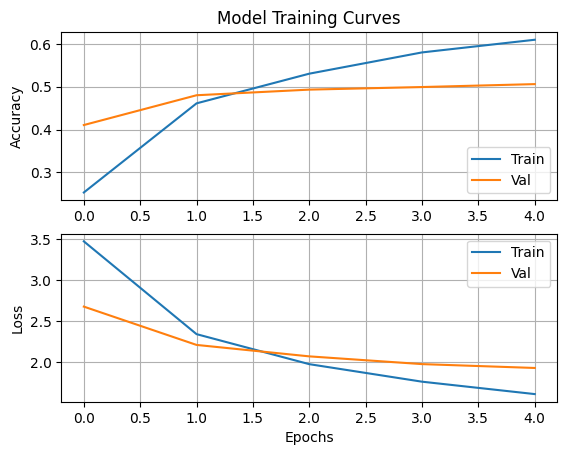

In [13]:
hf.plot_training_curves(history_all_classes_10_percent)

## 3. Fine-tuning el modelo de extracción de características

Después de entrenar el modelo de extracción de características, vamos a fine-tuning el modelo por 5 epocas adicionales con el 10% de los datos de Food101.

In [14]:
# Cargar los pesos del modelo entrenado
model.load_weights(checkpoint_path)

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompilar el model con tasa de aprendizaje menor
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 5 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=initial_epochs + fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 66s 251ms/step - loss: 1.3541 - accuracy: 0.6450 - val_loss: 1.9471 - val_accuracy: 0.4950
Epoch 6/10
237/237 [==============================] - 54s 225ms/step - loss: 1.2426 - accuracy: 0.6723 - val_loss: 1.9008 - val_accuracy: 0.5056
Epoch 7/10
237/237 [==============================] - 53s 219ms/step - loss: 1.1605 - accuracy: 0.6912 - val_loss: 1.8949 - val_accuracy: 0.5119
Epoch 8/10
237/237 [==============================] - 53s 222ms/step - loss: 1.0839 - accuracy: 0.7149 - val_loss: 1.8903 - val_accuracy: 0.5079
Epoch 9/10
237/237 [==============================] - 51s 212ms/step - loss: 1.0105 - accuracy: 0.7344 - val_loss: 1.8697 - val_accuracy: 0.5177
Epoch 10/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9678 - accuracy: 0.7411 - val_loss: 1.8684 - val_accuracy: 0.5201


In [20]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 71s 90ms/step - loss: 1.6293 - accuracy: 0.5732


[1.6292871236801147, 0.5732277035713196]

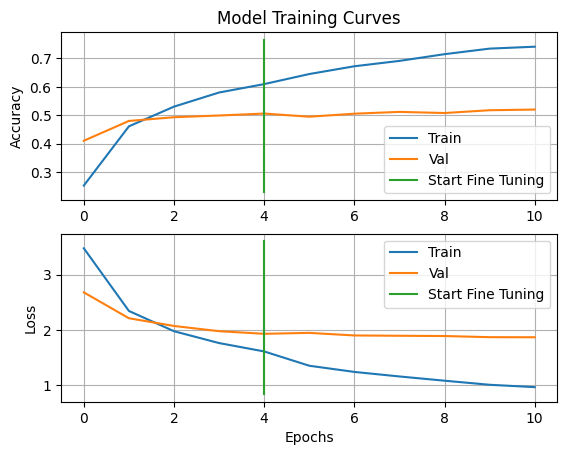

In [21]:
hf.compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=initial_epochs)

## 4. Salvar y cargar el modelo entrenado

Vamos a salvar el modelo entrenado y cargarlo para hacer predicciones con el modelo entrenado. La función `save_model()` de TensorFlow nos permite salvar un modelo entrenado. La función `load_model()` de TensorFlow nos permite cargar un modelo entrenado. Ambas funciones se encuentran en el módulo `tf.keras.models`.

In [22]:
# Guardar el modelo
model.save("101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: 101_food_class_10_percent_saved_big_dog_model\assets


c:\Users\diego\anaconda3\envs\gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [23]:
model = tf.keras.models.load_model("101_food_class_10_percent_saved_big_dog_model")

In [24]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 68s 84ms/step - loss: 1.6293 - accuracy: 0.5732


(1.6292871236801147, 0.5732277035713196)